In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import sklearn, sklearn.metrics

import glob
import captum
import latentshift
import classifiers
import ct_models
import ct_datasets

/tmp/ipykernel_19054/1991387906.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda'

In [4]:
model = classifiers.phecode.PheCodeClassifier().to(device)

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
weights_path = '/home/groups/akshaysc/joecohen/weights/'
ae_folder = '2023-07-27T19-35-51_ct_vqgan_sdd'
ae = ct_models.VQGAN(
    ckpt_path=f'{weights_path}/{ae_folder}/checkpoints/last.ckpt',
    yaml_path=glob.glob(f'{weights_path}/{ae_folder}/configs/*-project.yaml')[0],
    resize=256,
).to(device)

Working with z of shape (1, 64, 16, 16) = 16384 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
!ls /home/users/joecohen/group/phecode_scans/pacemaker/

AC423c71a_0000.nii.gz  AC4240355_0000.nii.gz  AC4242a48_0000.nii.gz
AC423d550_0000.nii.gz  AC4240711_0000.nii.gz  AC424343e_0000.nii.gz
AC423efff_0000.nii.gz  AC42409a7_0000.nii.gz  isolated_scans.zip
AC4240174_0000.nii.gz  AC4240d86_0000.nii.gz  __MACOSX


In [7]:
data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/group/phecode_scans/obesity/AC42441af_0000')

In [8]:
img = data[0]['image'][None,...]
img.shape

torch.Size([1, 1, 224, 224, 160])

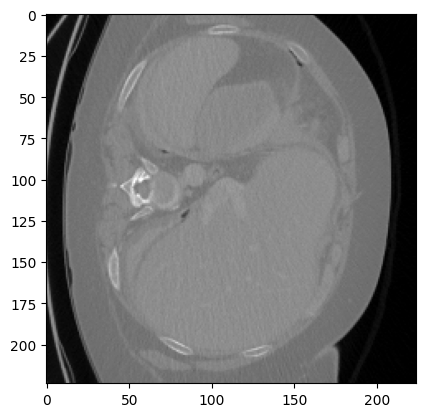

In [9]:
plt.imshow(img[0,0,:,:,140], cmap='gray');

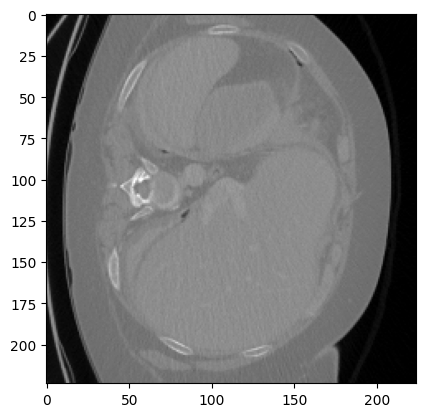

In [10]:
x = img[:,:,:,:,140]
x = torch.from_numpy(ct_datasets.Resize(224)(x[0,0])[None,None])
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [11]:
z = ae.encode(x.cuda())

In [12]:
img2 = ae.decode(z)

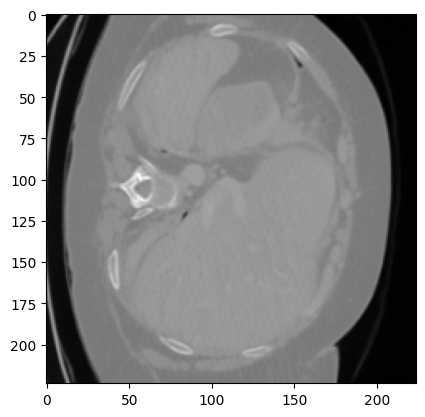

In [13]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [14]:
np.asarray(model.targets)[['pain' in target for target in model.targets]]

array(['Acute pain', 'Chronic pain',
       'Complex regional/central pain syndrome', 'Chronic pain syndrome',
       'Nonspecific chest pain', 'Precordial pain', 'Throat pain',
       'Back pain', 'Abdominal pain'], dtype='<U120')

In [15]:
np.asarray(model.targets)[['pace' in target for target in model.targets]]

array(['Swelling, mass, or lump in head and neck [Space-occupying lesion, intracranial NOS]',
       'Cardiac pacemaker/device in situ', 'Cardiac pacemaker in situ'],
      dtype='<U120')

In [16]:
np.asarray(model.targets)[['weight' in target for target in model.targets]]

array(['Overweight, obesity and other hyperalimentation',
       'Abnormal weight gain',
       'Short gestation; low birth weight; and fetal growth retardation'],
      dtype='<U120')

In [20]:
attr = captum.attr.LatentShift(
    latentshift.alignment.ModelWrapper(
        model, 
        target='Overweight, obesity and other hyperalimentation', 
        adjustment=lambda x: x+4, 
        rename_model='', sigmoid=True), 
    ct_models.SliceAEFull(ae, 105,115),
)
output = attr.attribute(img.cuda(), target=0,
                        #fix_range=[-20000,0], 
                        return_dicts = True,
                        apply_sigmoid = False,
                        search_max_steps = 20000,
                       )[0]
#plt.imshow(output['heatmap'][0]);

Shift: 0, Pred: 0.49382027983665466, pixel_diff: 0.0, sum*diff_pct: 167060.484375
Shift: -10.0, Pred: 0.4936925172805786, pixel_diff: 1.085681676864624, sum*diff_pct: 167060.484375
Shift: -21.0, Pred: 0.4935537874698639, pixel_diff: 2.280705690383911, sum*diff_pct: 167060.484375
Shift: -34.0, Pred: 0.49339011311531067, pixel_diff: 3.6942262649536133, sum*diff_pct: 167060.484375
Shift: -48.0, Pred: 0.4932151436805725, pixel_diff: 5.217644691467285, sum*diff_pct: 167060.484375
Shift: -63.0, Pred: 0.4930303692817688, pixel_diff: 6.8512492179870605, sum*diff_pct: 167060.484375
Shift: -80.0, Pred: 0.4928241968154907, pixel_diff: 8.703883171081543, sum*diff_pct: 167060.484375
Shift: -98.0, Pred: 0.49260765314102173, pixel_diff: 10.667207717895508, sum*diff_pct: 167060.484375
Shift: -118.0, Pred: 0.49236977100372314, pixel_diff: 12.85016918182373, sum*diff_pct: 167060.484375
Shift: -140.0, Pred: 0.4921116530895233, pixel_diff: 15.25337028503418, sum*diff_pct: 167060.484375
Shift: -164.0, Pred

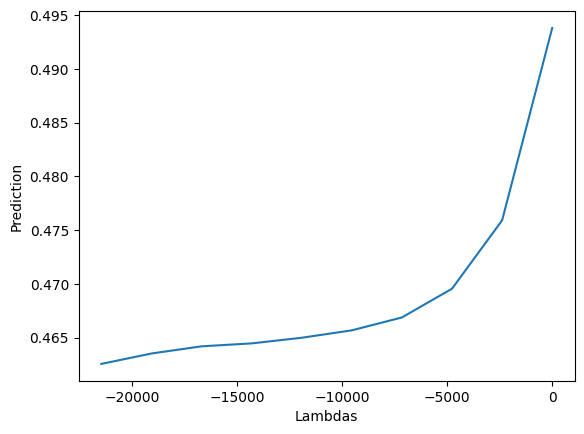

In [21]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

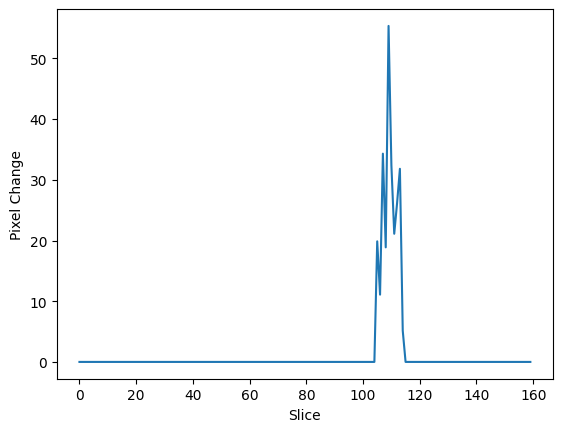

In [22]:
plt.plot(np.abs(output['heatmap']).sum(0).sum(0).sum(0));
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [23]:
output['heatmap'].shape

(1, 224, 224, 160)

In [24]:
idx = output['heatmap'].sum(1).sum(1).argmax()
idx

109

In [25]:
idx =109

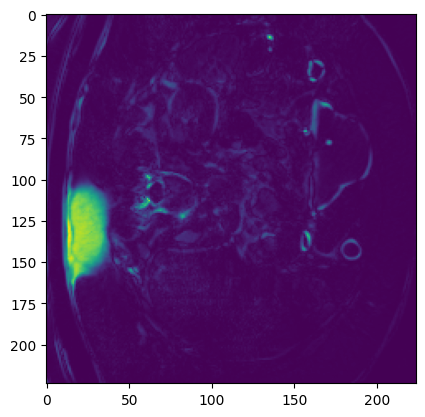

In [26]:
plt.imshow(output['heatmap'][0,:,:,idx]);

In [27]:
images = [output['generated_images'][i, :,:,:,idx] for i in range(len(output['generated_images']))]

In [28]:
images[0].shape

(1, 224, 224)

In [29]:
np.asarray(images).mean((1,2,3))

array([0.4559695 , 0.45620587, 0.45650893, 0.45692986, 0.457546  ,
       0.45848584, 0.4596261 , 0.46020627, 0.4604842 , 0.46065634],
      dtype=float32)

In [30]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':output['preds']}, "test", show_pred=True, watermark=False, cmap='gray', 
                                       extra_loops=0,
                                      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg',
                                      resize=512)


/share/software/user/open/ffmpeg/5.0/bin/ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=-1.0 Lsize=      75kB time=00:00:00.76 bitrate= 810.9kbits/s speed= 3.8x    


In [31]:
outputs = []
batch_size = 10
for i in range(0, img.shape[-1], batch_size):
    print(f'Slices {i}-{i+batch_size}')
    attr = captum.attr.LatentShift(
        latentshift.alignment.ModelWrapper(
            model, 
            target='Cardiac pacemaker in situ',
            adjustment=lambda x: x+8, 
            rename_model='', sigmoid=True),
        ct_models.SliceAEFull(ae, i, i+batch_size)
    )
    output = attr.attribute(img.cuda(), target=0,
                            #fix_range=[-6000,0],
                            return_dicts = True,
                            apply_sigmoid = False,
                            lambda_sweep_steps = 2,
                            search_max_steps = 20000,
                            verbose=False,
                           )[0]
    outputs.append(output)

Slices 0-10
Slices 10-20
Slices 20-30
Slices 30-40
Slices 40-50
Slices 50-60
Slices 60-70
Slices 70-80
Slices 80-90
Slices 90-100
Slices 100-110
Slices 110-120
Slices 120-130
Slices 130-140
Slices 140-150
Slices 150-160


In [32]:
len(outputs)

16

In [33]:
pred_changes = np.concatenate([[np.min(o['preds'])]*batch_size for o in outputs])

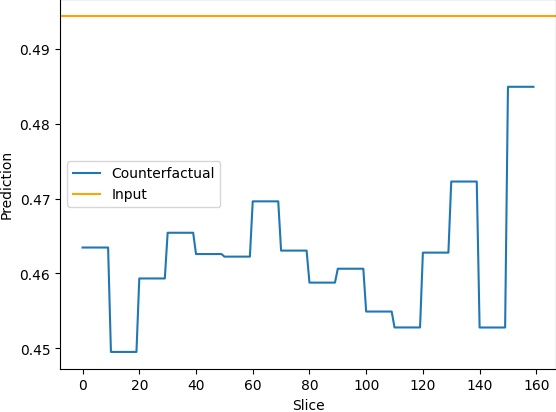

In [34]:
plt.plot(pred_changes, label='Counterfactual');
plt.axhline(outputs[0]['preds'][-1], label='Input', c='orange')
plt.xlabel('Slice');
plt.ylabel('Prediction');
plt.legend();

In [35]:
heatmaps = np.concatenate([o['heatmap'] for o in outputs], 3)

In [36]:
raw_diffs = np.concatenate([np.abs(o['heatmap']).sum(0).sum(0).sum(0) for o in outputs])
diffs = raw_diffs[raw_diffs != 0]

In [37]:
heatmaps1 = heatmaps[:,:,:,raw_diffs != 0]

In [38]:
images_reconstruction = np.concatenate([o['generated_images'][-1] for o in outputs], 3)
images_counterfactual = np.concatenate([o['generated_images'][0] for o in outputs], 3)

In [39]:
images_reconstruction = images_reconstruction[...,raw_diffs != 0]
images_counterfactual = images_counterfactual[...,raw_diffs != 0]

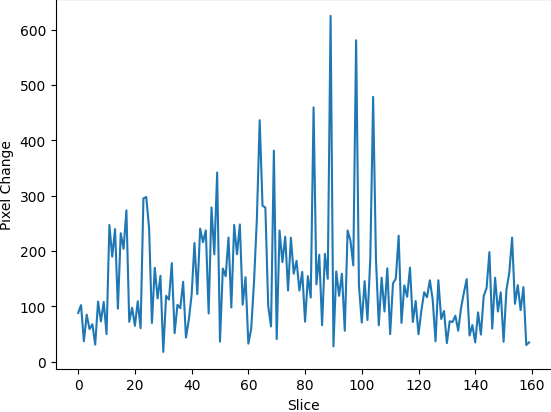

In [40]:
plt.plot(diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [41]:
np.argmax(diffs)

89

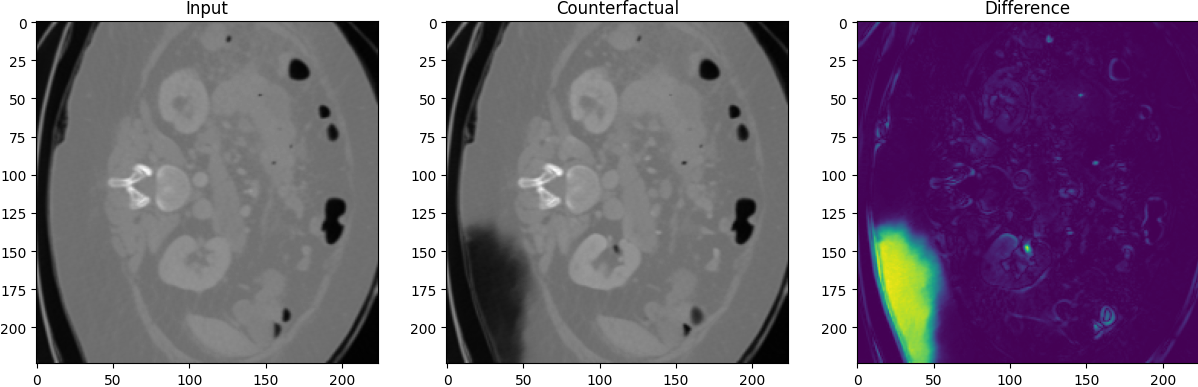

In [47]:
idx_slice = 89
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');

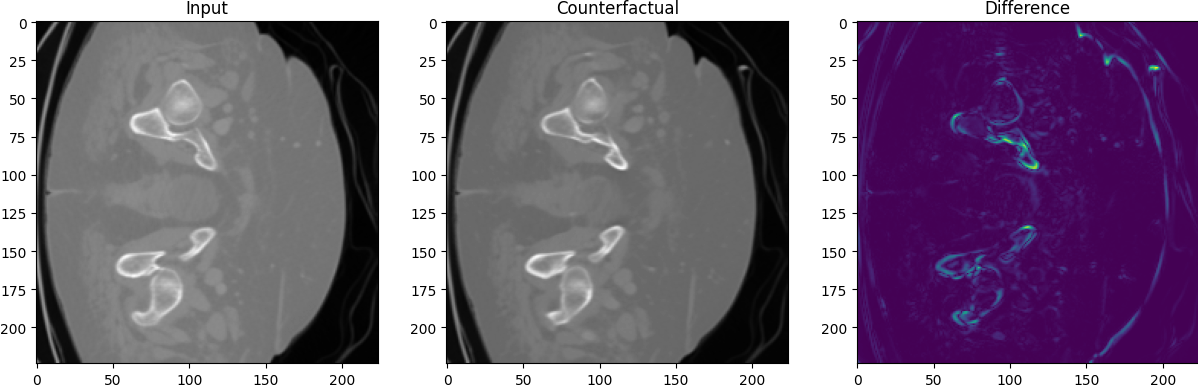

In [48]:
idx_slice = 15
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');

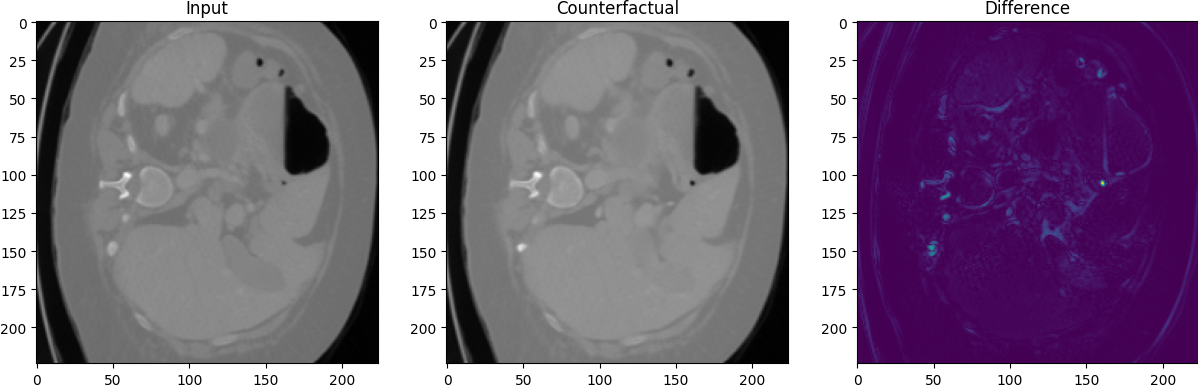

In [44]:
idx_slice = 115
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');

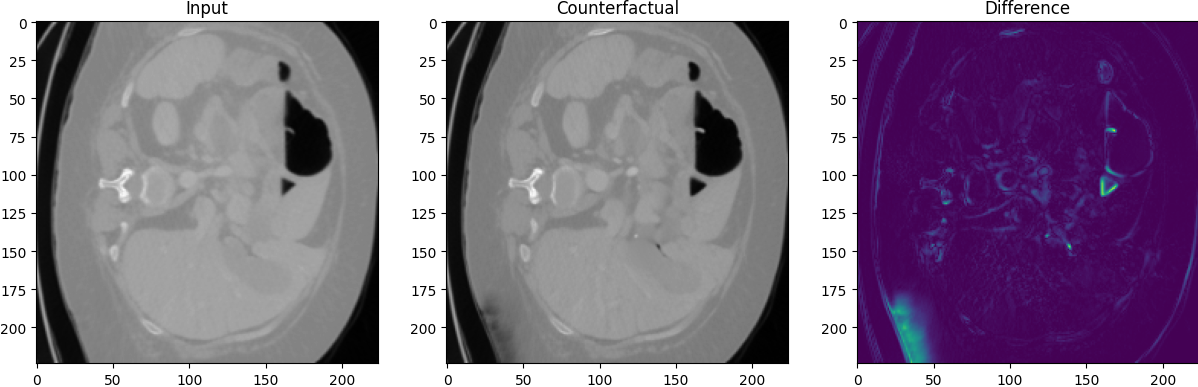

In [45]:
idx_slice = 113
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');

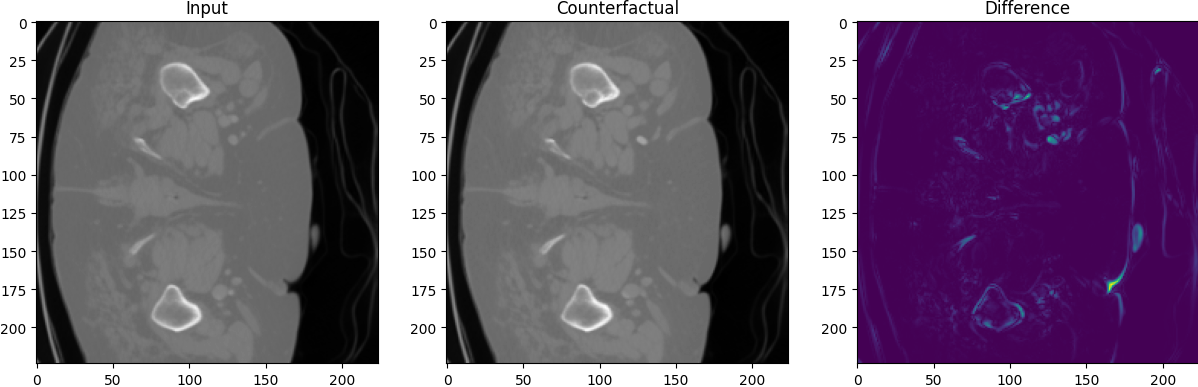

In [46]:
idx_slice = 1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0,:,:,idx_slice], cmap='gray')
axs[0].set_title('Input')
axs[1].imshow(images_counterfactual[0,:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual')
axs[2].imshow(heatmaps1[0,:,:,idx_slice])
axs[2].set_title('Difference');